### Reduced-order-model simulation
The code in the notebook simulates the ROM produced by the DRA method for an example UDDS profile. Its first main purpose is to demonstrate that the simulation itself is quite fast, similar to the speed of a four resistor-capacitor equivalent-circuit model. Its second main purpose is for you to be able to compare the accuracy of the ROM predictions of internal electrochemical variables at different locations in the cell to the "truth" values provided by a pre-computed simulation of the PDE model (using the COMSOL program).

I do not comment on the implementation of the simulation, since that was not taught in this specialization. However, if you are curious, you can find much more detail in the references cited in the lesson. 

In [2]:
% The following function conducts the simulation for current profile "ik", using ROM "ROM", starting 
% at initial SOC "SOC0". It produces a vector of cell voltages plus all of the internal electrochemical
% variables stored in fields of "ROMout".
function [Vcell,ROMout] = simROM(ik,ROM,SOC0)
  duration = size(ik,1);

  %% Load params into simple local variables
  % Convert Uocp_str to Uocp anonymous functions
  % Convert kappa_func_str to kappa_ref anonymous function
  cellData = ROM.cellData;
  cellData.neg.Uocp = eval(cellData.neg.Uocp_str);
  cellData.pos.Uocp = eval(cellData.pos.Uocp_str);
  if ~ischar(cellData.const.kappa_ref),
    cellData.const.kappa_ref = sprintf('(@(x)(%g))',cellData.const.kappa_ref);
  end
  kappa_ref = eval(cellData.const.kappa_ref);

  R = 8.3144621;
  F = 96485.3365;
  t_plus = cellData.const.t_plus;
  Acell = cellData.const.Acell;
  Lneg =  cellData.neg.L;
  Lsep =  cellData.sep.L;
  Lpos =  cellData.pos.L;
  Ltot =  Lneg + Lsep + Lpos;
  csmax_neg = cellData.neg.csmax;
  csmax_pos = cellData.pos.csmax;
  alpha_neg = cellData.neg.alpha;
  alpha_pos = cellData.pos.alpha;
  ce0 = cellData.const.ce0;
  k_norm_neg = cellData.neg.k_norm;
  k_neg = k_norm_neg/csmax_neg/ce0^(1-alpha_neg);
  k_norm_pos = cellData.pos.k_norm;
  k_pos = k_norm_pos/csmax_pos/ce0^(1-alpha_pos);
  as_neg = 3*cellData.neg.eps_s/cellData.neg.Rs;
  as_pos = 3*cellData.pos.eps_s/cellData.pos.Rs;
  Rfilm_neg = cellData.neg.Rfilm;
  Rfilm_pos = cellData.pos.Rfilm;
  Tref = cellData.const.Tref;
  Eact_kappa = cellData.const.Eact_kappa;
  Eact_sigma = cellData.neg.Eact_sigma;
  brug_kappa_neg = cellData.neg.brug_kappa;
  brug_kappa_sep = cellData.sep.brug_kappa;
  brug_kappa_pos = cellData.pos.brug_kappa;
  brug_sigma_neg = cellData.neg.brug_sigma;
  brug_sigma_pos = cellData.pos.brug_sigma;
    
  %% Find indices of outputs in model structure, to be used later
  j_neg_ind   = find(strcmp(cellData.tf.name,'j_neg') == 1);  
  j_0_ind     = find(strcmp(cellData.tf.name,'j_neg') == 1 & cellData.tf.val == 0);
  j_neg_locs  = cellData.tf.val(j_neg_ind);                  
  cse_neg_ind = find(strcmp(cellData.tf.name,'cse_neg') == 1);
  cse_0_ind   = find(strcmp(cellData.tf.name,'cse_neg') == 1 & cellData.tf.val == 0);
  cse_neg_locs = cellData.tf.val(cse_neg_ind);                            
  phis_neg_ind = find(strcmp(cellData.tf.name,'phis_neg') == 1);
  j_pos_ind    = find(strcmp(cellData.tf.name,'j_pos') == 1);
  j_L_ind      = find(strcmp(cellData.tf.name,'j_pos') == 1 & cellData.tf.val == 0);
  j_pos_locs   = cellData.tf.val(j_pos_ind);                                  
  cse_pos_ind  = find(strcmp(cellData.tf.name,'cse_pos') == 1);
  cse_L_ind    = find(strcmp(cellData.tf.name,'cse_pos') == 1 & cellData.tf.val == 0);
  cse_pos_locs = cellData.tf.val(cse_pos_ind);                                  
  phis_pos_ind = find(strcmp(cellData.tf.name,'phis_pos') == 1);
  phie1_ind    = find(strcmp(cellData.tf.name,'phie1') == 1); 
  ce_ind       = find(strcmp(cellData.tf.name,'ce') == 1);
  ce_locs      = cellData.tf.val(ce_ind);                  
  phise_neg_0_ind = find(strcmp(cellData.tf.name,'phise_neg') == 1 & cellData.tf.val == 0);

  %% Create storage for variables of interest
  j_neg = zeros(duration,length(j_neg_ind));
  j_0 = zeros(duration,length(j_0_ind));
  eta_neg = zeros(duration,length(j_neg_ind));
  eta_0 = zeros(duration,length(j_0_ind));
  cse_neg = zeros(duration,length(cse_neg_ind));
  cse_0 = zeros(duration,length(cse_0_ind));
  phi_s_neg = zeros(duration,length(phis_neg_ind));
  j_pos = zeros(duration,length(j_pos_ind));
  j_L = zeros(duration,length(j_L_ind));
  eta_pos = zeros(duration,length(j_pos_ind));
  eta_L = zeros(duration,length(j_L_ind));
  cse_pos = zeros(duration,length(cse_pos_ind));
  cse_L = zeros(duration,length(cse_L_ind));
  phi_s_pos = zeros(duration,length(phis_pos_ind));
  phi_e = zeros(duration,length(phie1_ind)+1);
  phi_e_tilde_1 = zeros(duration,length(phie1_ind));
  ce = zeros(duration,length(ce_ind));
  phise_neg_0 = zeros(duration,length(phise_neg_0_ind));
  Vcell = zeros(duration,1);
    
  %% Verify that signals required to compute cell voltage exist
  % Need:
  %  1. cse_neg at the current collector (cse_0 not empty)
  %  2. cse_pos at the current collector (cse_L not empty)
  %  3. j at both current collectors (j_0 and j_L not empty)
  %  4. phi_e_tilde_1 at the L location
  %  5. ce at location 0 and L
  %  6. phise at the neg current collector (phise_neg_0 not empty)
  if isempty(cse_0_ind), warning('cse_0 not found!'); end
  if isempty(cse_L_ind), warning('cse_L not found!'); end
  if isempty(j_0_ind),   warning('j_0 not found!');  end
  if isempty(j_L_ind),   warning('j_L not found!'); end
  xphie = cellData.tf.val(phie1_ind);
  if xphie(1) == 0,
    warning('First phi_e xlocation should not be zero. Ignoring');
    phie1_ind = phie1_ind(2:end);
  end 
  if (xphie(end) > Ltot+eps) || (xphie(end) < Ltot-eps), 
    warning(['Assuming that last phi_e xlocation is at pos'...
             ' current collector but is at: %g'],xphie(end));
  end 
  xce = cellData.tf.val(ce_ind);
  if xce(1) > 0,
    warning(['Assuming that first c_e xlocation is at neg'...
             ' current collector but is at: %g'],xce(1)); 
  end
  if (xce(end) > Ltot+eps) || (xce(end) < Ltot-eps),
    warning(['Assuming that last c_e xlocation is at pos'...
             ' current collector but is at: %g'],xce(end));
  end    
  if isempty(phise_neg_0_ind), warning('phise_neg_0 not found!'); end

  %% Verify that all signals needed to compute eta exist
  [C,~,IB] = intersect(j_neg_locs,cse_neg_locs);
  if length(C) < length(j_neg_locs),
    warning('Cannot compute eta in negative electrode');
  else
    eta_neg_cse_ind = IB;
    ce_neg_locs = ce_locs(ce_locs < Lneg+eps)/Lneg;
    if length(intersect(j_neg_locs,ce_neg_locs)) < length(j_neg_locs),
      warning('Cannot compute eta in negative electrode');
    else
      eta_neg_ce_ind = find(ce_locs < Lneg+eps);
    end
  end
  [C,~,IB] = intersect(j_pos_locs,cse_pos_locs);
  if length(C) < length(j_pos_locs),
    warning('Cannot compute eta in positive electrode');
  else
    eta_pos_cse_ind = IB;
    ce_pos_locs = 1 - (ce_locs(ce_locs > Lneg+Lsep-eps) - Lneg - Lsep)/Lpos;
    if length(intersect(round(1e6*j_pos_locs),round(1e6*ce_pos_locs))) < length(j_pos_locs),
      warning('Cannot compute eta in positive electrode');
    else
      eta_pos_ce_ind = flipud(find(ce_locs > Lneg+Lsep-eps));
    end
  end
  
  %% Find intial electrode SOC 
  neg100 = cellData.neg.theta100;
  neg0 = cellData.neg.theta0;
  SOC_neg = SOC0*(neg100-neg0)+neg0;

  pos100 = cellData.pos.theta100;
  pos0 = cellData.pos.theta0;
  SOC_pos = SOC0*(pos100-pos0)+pos0; 

  %%  Set up simulation
  A = ROM.A;
  B = ROM.B;
  C = ROM.C;
  D = ROM.D;

  numstates = size(A,1);
  numoutstates = size(C,1);
  x = zeros(duration,numstates); % from x0...xN
  theta_neg = zeros(1,duration); % from x0...xN
  theta_pos = zeros(1,duration); % from x0...xN
  cell_SOC = zeros(duration,1);  % from x0...xN

  out = zeros(duration,numoutstates); % from y1...yN
  x(1,:) = zeros(1,numstates); % initialize state
  theta_neg(1) = SOC_neg;
  theta_pos(1) = SOC_pos;
  cell_SOC(1) = (SOC_neg - neg0)/(neg100 - neg0);
  
  integral_cs_neg_gain = C(cse_neg_ind(1),end); 
  integral_cs_pos_gain = C(cse_pos_ind(1),end); 

  
  %% -----------------------------------------------------------------
  %  Main simulation loop
  %  -----------------------------------------------------------------
  for k = 0:duration-1, % k = time / deltaTime
    % Step 1: Update SOC values at this time step
    cs_neg_avg = integral_cs_neg_gain*x(k+1,end) + csmax_neg*SOC_neg;
    if cs_neg_avg < 0,
      warning('cs_neg_avg < 0'); cs_neg_avg = 0;
    end
    if cs_neg_avg > csmax_neg,
      warning('cs_neg_avg > csmax_neg'); cs_neg_avg = csmax_neg;
    end
    cs_pos_avg = integral_cs_pos_gain*x(k+1,end) + csmax_pos*SOC_pos;
    if cs_pos_avg < 0,
      warning('cs_pos_avg < 0'); cs_pos_avg = 0;
    end
    if cs_pos_avg > csmax_pos,
      warning('cs_pos_avg > csmax_pos'); cs_pos_avg = csmax_pos;
    end
    theta_neg(k+1) = cs_neg_avg/csmax_neg; 
    theta_pos(k+1) = cs_pos_avg/csmax_pos;
    cell_SOC(k+1)  = (theta_neg(k+1) - neg0)/(neg100 - neg0);
    
    % Print the current iteration number, SOC at intermediate points in the simulation
    if (rem(k,100) == 0), fprintf('  ... time = %d, SOC = %2.8f\n',k,cell_SOC(k+1)); end
    
    % Step 2: Compute linear outputs
    %         y[k] = C[k]*x[k] + D[k]*u[k]
    out(k+1,:) = C*x(k+1,:)' + D*ik(k+1);

    % Step 3: Parse outputs into output variables, and add affine and
    %         nonlinear corrections, as appropriate
    outk = out(k+1,:);
    % Step 3a: Compute solid surface concentration 
    cse_neg(k+1,:) = outk(cse_neg_ind) + csmax_neg*SOC_neg; 
    if any(cse_neg(k+1,:) < 0),
      warning('cse_neg < 0'); cse_neg(cse_neg < 0) = 0;
    end
    if any(cse_neg(k+1,:) > csmax_neg),
      warning('cse_neg > csmax_neg'); 
      cse_neg(cse_neg > csmax_neg) = csmax_neg;
    end
    cse_0(k+1,:) = outk(cse_0_ind) + csmax_neg*SOC_neg; 
    if any(cse_0(k+1,:) < 0),
      warning('cse_0 < 0'); cse_0(cse_0 < 0) = 0;
    end
    if any(cse_0(k+1,:) > csmax_neg),
      warning('cse_0 > csmax_neg'); 
      cse_0(cse_0 > csmax_neg) = csmax_neg;
    end
    cse_pos(k+1,:) = outk(cse_pos_ind) + csmax_pos*SOC_pos;
    if any(cse_pos(k+1,:) < 0),
      warning('cse_pos < 0'); cse_pos(cse_pos < 0) = 0;
    end
    if any(cse_pos(k+1,:) > csmax_pos),
      warning('cse_pos > csmax_pos'); 
      cse_pos(cse_pos > csmax_pos) = csmax_pos;
    end
    cse_L(k+1,:) = outk(cse_L_ind) + csmax_pos*SOC_pos;
    if any(cse_L(k+1,:) < 0),
      warning('cse_L < 0'); cse_L(cse_L < 0) = 0;
    end
    if any(cse_L(k+1,:) > csmax_pos),
      warning('cse_L > csmax_pos'); 
      cse_L(cse_L > csmax_pos) = csmax_pos;
    end

    % Step 3b: Compute electrolyte concentration
    ce(k+1,:) = outk(ce_ind) + ce0;
    if any(ce(k+1,:) < 0),
      warning('ce < 0'); ce(ce < 0) = eps;
    end

    % Step 3c: Compute solid-electrolyte potential difference
    uocp_neg_avg = cellData.neg.Uocp{1}(theta_neg(k+1));
    phise_neg_0(k+1,:) = outk(phise_neg_0_ind) + uocp_neg_avg;
    
    % Step 3d: Compute phi_e
    phi_e_tilde_1(k+1,:) = outk(phie1_ind);
    phi_e_tilde_2 = 2*R*298.15/F*(1-t_plus)*log(ce(k+1,:)/ce(k+1,1));    
    phi_e(k+1,:) = [0 phi_e_tilde_1(k+1,:)] + phi_e_tilde_2 - ...
                         phise_neg_0(k+1,:);

    % Step 3e: Compute j
    j_neg(k+1,:) = outk(j_neg_ind);
    j_0(k+1,:) = outk(j_0_ind);
    j_pos(k+1,:) = outk(j_pos_ind);
    j_L(k+1,:) = outk(j_L_ind);
    
    % correct eta variable via asinh method
    j0_neg_cc_actual = max(eps,k_neg*(csmax_neg-cse_0(k+1))^(1-alpha_neg)*...
                       cse_0(k+1)^alpha_neg*ce(k+1,1)^(1-alpha_neg));
    j0_neg_actual  = max(eps,k_neg*(csmax_neg-cse_neg(k+1,eta_neg_cse_ind)).^(1-alpha_neg).* ... % 20140521
                       cse_neg(k+1,eta_neg_cse_ind).^alpha_neg.*ce(k+1,eta_neg_ce_ind).^(1-alpha_neg));                    
    eta_neg(k+1,:) = 2*R*298.15/F*asinh(j_neg(k+1,:)./(2*j0_neg_actual)); % 20140521
    eta_0(k+1,:)   = 2*R*298.15/F*asinh(j_0(k+1,:)/(2*j0_neg_cc_actual));
    j0_pos_cc_actual = max(eps,k_pos*(csmax_pos-cse_L(k+1))^(1-alpha_pos).*...
                       cse_L(k+1)^alpha_pos*ce(k+1,end)^(1-alpha_pos));
    j0_pos_actual  = max(eps,k_pos*(csmax_pos-cse_pos(k+1,eta_pos_cse_ind)).^(1-alpha_pos).* ... % 20140521
                       cse_pos(k+1,eta_pos_cse_ind).^alpha_pos.*ce(k+1,eta_pos_ce_ind).^(1-alpha_pos));                    
    eta_pos(k+1,:) = 2*R*298.15/F*asinh(j_pos(k+1,:)./(2*j0_pos_actual)); % 20140521
    eta_L(k+1,:)   = 2*R*298.15/F*asinh(j_L(k+1,:)/(2*j0_pos_cc_actual));
        
    % Step 3g: Compute cell voltage
    Uocp_0 = cellData.neg.Uocp{1}(cse_0(k+1,:)/csmax_neg);
    Uocp_L = cellData.pos.Uocp{1}(cse_L(k+1,:)/csmax_pos); 
    Vcell(k+1) = eta_L(k+1,:) - eta_0(k+1,:) + Uocp_L - Uocp_0 + ...
               phi_e_tilde_1(k+1,end) + phi_e_tilde_2(end) + ...
               F*(Rfilm_pos*j_L(k+1,:) - Rfilm_neg*j_0(k+1,:));
             
    % Step 3h: Compute phi_s
    phi_s_neg(k+1,:) = outk(phis_neg_ind);
    phi_s_pos(k+1,:) = outk(phis_pos_ind) + Vcell(k+1);
       
    % Step 4: Update state equation
    %         x[k] = A[k-1]*x[k-1] + B[k-1]*u[k-1]
    x(k+2,:) = A*x(k+1,:)' + B*ik(k+1); 
  end % run simulation loop
      
  %% Return values as a structure
  %   ROM.j0_pos_cc_actual = j0_pos_cc_actual;
  %   ROM.j0_neg_cc_actual = j0_neg_cc_actual;
  %   ROM.cs_neg_avg = cs_neg_avg;
  %   ROM.theta_neg = theta_neg;
  %   ROM.theta_pos = theta_pos;
  ROMout.cellData = cellData;
  ROMout.time = 0:length(Vcell)-1; 
  ROMout.time = ROM.draData.Tsamp*ROMout.time(:);
  ROMout.Iapp = ik;
  ROMout.Vcell = Vcell;
  ROMout.SOC = cell_SOC;
  
  ROMout.j_neg = j_neg;
  ROMout.eta_neg = eta_neg;
  ROMout.cse_neg = cse_neg;
  ROMout.phis_neg = phi_s_neg;

  ROMout.j_pos = j_pos;
  ROMout.eta_pos = eta_pos;
  ROMout.cse_pos = cse_pos;
  ROMout.phis_pos = phi_s_pos;
  
  ROMout.phie = phi_e;
  ROMout.ce = ce;

  ROMout.locs.j_neg_locs = cellData.tf.val(j_neg_ind);
  ROMout.locs.eta_neg_locs = ROMout.locs.j_neg_locs;
  ROMout.locs.cse_neg_locs = cellData.tf.val(cse_neg_ind);
  ROMout.locs.phis_neg_locs = cellData.tf.val(phis_neg_ind);
  
  ROMout.locs.j_pos_locs = cellData.tf.val(j_pos_ind);
  ROMout.locs.eta_pos_locs = ROMout.locs.j_pos_locs;
  ROMout.locs.cse_pos_locs = cellData.tf.val(cse_pos_ind);
  ROMout.locs.phis_pos_locs = cellData.tf.val(phis_pos_ind);

  ROMout.locs.phie_locs = [0; cellData.tf.val(phie1_ind)];
  ROMout.locs.phie_neg_locs = ROMout.locs.phie_locs;
  ROMout.locs.phie_neg_locs(ROMout.locs.phie_locs > cellData.neg.L + eps) = [];
  ROMout.locs.phie_sep_locs = ROMout.locs.phie_locs;
  ROMout.locs.phie_sep_locs(ROMout.locs.phie_sep_locs < cellData.neg.L - eps) = [];
  ROMout.locs.phie_sep_locs(ROMout.locs.phie_sep_locs > cellData.neg.L + cellData.sep.L + eps) = [];  
  ROMout.locs.phie_pos_locs = ROMout.locs.phie_locs;
  ROMout.locs.phie_pos_locs(ROMout.locs.phie_locs < cellData.neg.L + cellData.sep.L - eps) = [];  
  ROMout.locs.ce_locs = cellData.tf.val(ce_ind);
  ROMout.locs.ce_neg_locs = ROMout.locs.ce_locs;
  ROMout.locs.ce_neg_locs(ROMout.locs.ce_locs > cellData.neg.L + eps) = [];
  ROMout.locs.ce_sep_locs = ROMout.locs.ce_locs;
  ROMout.locs.ce_sep_locs(ROMout.locs.ce_sep_locs < cellData.neg.L - eps) = [];
  ROMout.locs.ce_sep_locs(ROMout.locs.ce_sep_locs > cellData.neg.L + cellData.sep.L + eps) = [];      
  ROMout.locs.ce_pos_locs = ROMout.locs.ce_locs;
  ROMout.locs.ce_pos_locs(ROMout.locs.ce_locs < cellData.neg.L + cellData.sep.L - eps) = [];
end

In [3]:
load('./readonly/cell_doyle_ROM_60SOC_25C_4x_2x20050.mat'); % load ROM files generated by DRA
UDDS = load('./readonly/UDDS_2C_SOCconst.txt'); % load stimulus to use for simulation

soc0 = 0.6;
ivec = [0; UDDS(1:end-1,2)]*20.5; % UDDS scaled to maximum of 2C rate
fprintf('Starting to run 1500-second simulation...\n');
tic
[Vcell,ROM] = simROM(ivec,ROM,soc0);
fprintf('  simulation complete.\n'); toc

Starting to run 1500-second simulation...
  ... time = 0, SOC = 0.60000000
  ... time = 100, SOC = 0.59859926
  ... time = 200, SOC = 0.59355251
  ... time = 300, SOC = 0.59102356
  ... time = 400, SOC = 0.59017801
  ... time = 500, SOC = 0.59146184
  ... time = 600, SOC = 0.59253708
  ... time = 700, SOC = 0.59347131
  ... time = 800, SOC = 0.59179210
  ... time = 900, SOC = 0.59358539
  ... time = 1000, SOC = 0.59457000
  ... time = 1100, SOC = 0.59556095
  ... time = 1200, SOC = 0.59681950
  ... time = 1300, SOC = 0.59905737
  ... time = 1400, SOC = 0.60000000
  ... time = 1500, SOC = 0.60000000
  simulation complete.
Elapsed time is 1.60283 seconds.


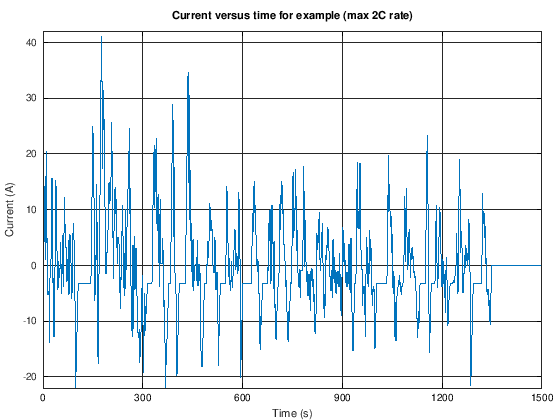

In [4]:
% Plot current for this example
t = 0:length(ROM.Vcell)-1;
plot(t,ROM.Iapp); grid on;
set(gca,'xtick',0:300:1500); axis([0 1500 -22 42]);
title('Current versus time for example (max 2C rate)');
ylabel('Current (A)'); xlabel('Time (s)');

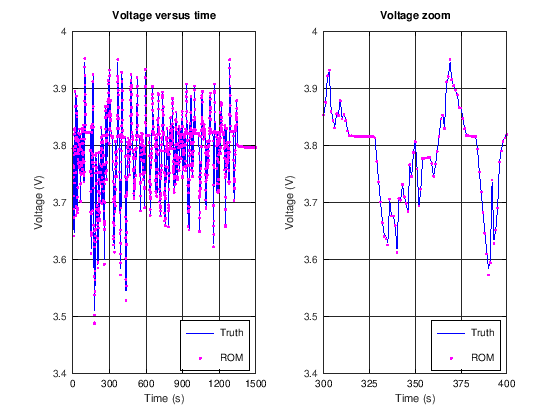

In [5]:
% Plot true and ROM-predicted voltage for this example
% First, load COMSOL pre-computed solution to full PDE model as "Truth" result
load('./readonly/doyle_udds_balanced_FOM'); % loads "FOM" variable, pre-computed via COMSOL

subplot(1,2,1);
plot(t,FOM.Vcell,'b-',t,ROM.Vcell,'m.','markersize',5); grid on
set(gca,'xtick',0:300:1500); xlim([0 1500]); legend('Truth','ROM','location','southeast')
title('Voltage versus time');
ylabel('Voltage (V)'); xlabel('Time (s)');

subplot(1,2,2)
plot(t,FOM.Vcell,'b-',t,ROM.Vcell,'m.','markersize',5); grid on
set(gca,'xtick',300:25:400); xlim([300 400]);  legend('Truth','ROM','location','southeast')
title('Voltage zoom');
ylabel('Voltage (V)'); xlabel('Time (s)');

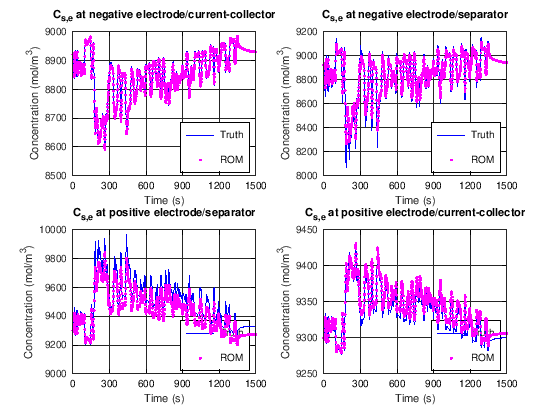

In [6]:
% Plot solid surface concentration at four locations in the cell
subplot(2,2,1); % negative electrode, at electrode/current-collector boundary
[~,ind] = min(ROM.locs.cse_neg_locs);
plot(t,FOM.cse_neg(:,1),'b-',t,ROM.cse_neg(:,ind),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{s,e} at negative electrode/current-collector');
legend('Truth','ROM','location','southeast');

subplot(2,2,2); % negative electrode, at electrode/separator boundary
[~,ind] = max(ROM.locs.cse_neg_locs);
plot(t,FOM.cse_neg(:,end),'b-',t,ROM.cse_neg(:,ind),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{s,e} at negative electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,3); % Positive electrode, at electrode/separator boundary
[~,ind] = max(ROM.locs.cse_pos_locs);
plot(t,FOM.cse_pos(:,1),'b-',t,ROM.cse_pos(:,ind),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{s,e} at positive electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,4); % Positive electrode, at electrode/current-collector boundary
[~,ind] = min(ROM.locs.cse_pos_locs);
plot(t,FOM.cse_pos(:,end),'b-',t,ROM.cse_pos(:,ind),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{s,e} at positive electrode/current-collector');
legend('Truth','ROM','location','southeast');

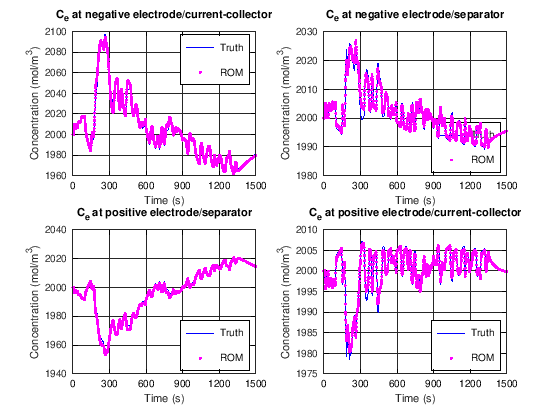

In [7]:
% Plot electrolyte concentration at four locations in the cell
subplot(2,2,1); % negative electrode, at electrode/current-collector boundary
[~,indROM] = min(ROM.locs.ce_neg_locs);
[~,indFOM] = min(FOM.locs.ce_neg_locs);
plot(t,FOM.ce(:,indFOM),'b-',t,ROM.ce(:,indROM),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{e} at negative electrode/current-collector');
legend('Truth','ROM','location','northeast');

subplot(2,2,2); % negative electrode, at electrode/separator boundary
[~,indROM] = max(ROM.locs.ce_neg_locs);
[~,indFOM] = max(FOM.locs.ce_neg_locs);
plot(t,FOM.ce(:,indFOM),'b-',t,ROM.ce(:,indROM),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{e} at negative electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,3); % Positive electrode, at electrode/separator boundary
LFOM = length(FOM.locs.ce_pos_locs);
LROM = length(ROM.locs.ce_pos_locs);
[~,indROM] = max(ROM.locs.ce_pos_locs);
[~,indFOM] = max(FOM.locs.ce_pos_locs);
plot(t,FOM.ce(:,end-LFOM+indFOM),'b-',t,ROM.ce(:,end-LROM+indROM),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{e} at positive electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,4); % Positive electrode, at electrode/current-collector boundary
[~,indROM] = min(ROM.locs.ce_pos_locs);
[~,indFOM] = min(FOM.locs.ce_pos_locs);
plot(t,FOM.ce(:,end-LFOM+indFOM),'b-',t,ROM.ce(:,end-LROM+indROM),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Concentration (mol/m^3)');
title('C_{e} at positive electrode/current-collector');
legend('Truth','ROM','location','southeast');

    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3


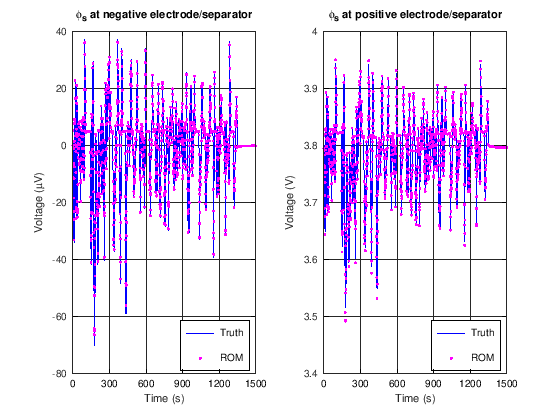

In [8]:
% Plot solid potential 
% (note: solid potential is defined to be zero at negative-electrode current collector, so is not plotted;
% it is equal to cell voltage at positive-electrode current collector, so is not plotted here either)
subplot(1,2,1);
[~,indSep] = max(ROM.locs.phis_neg_locs);
plot(t,1e6*FOM.phis_neg(:,end),'b-',t,1e6*ROM.phis_neg(:,indSep),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Voltage (\muV)');
title('\phi_{s} at negative electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(1,2,2);
[~,indSep] = max(ROM.locs.phis_pos_locs);
plot(t,FOM.phis_pos(:,1),'b-',t,ROM.phis_pos(:,indSep),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Voltage (V)');
title('\phi_{s} at positive electrode/separator');
legend('Truth','ROM','location','southeast');

    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3
    title at line 53 column 3


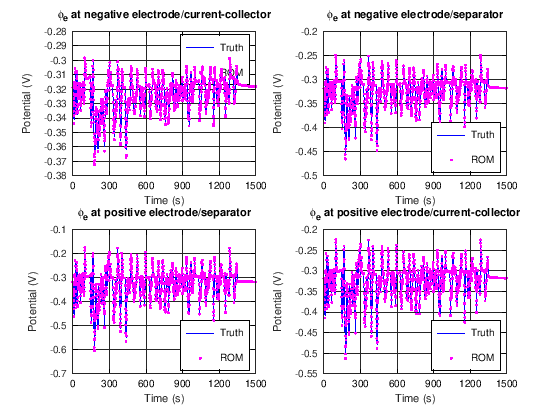

In [9]:
% Plot electrolyte potential at four locations in the cell
subplot(2,2,1); % negative electrode, at electrode/current-collector boundary
[~,indROM] = min(ROM.locs.phie_neg_locs);
[~,indFOM] = min(FOM.locs.phie_neg_locs);
plot(t,FOM.phie(:,indFOM),'b-',t,ROM.phie(:,indROM),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Potential (V)');
title('\phi_{e} at negative electrode/current-collector');
legend('Truth','ROM','location','northeast');

subplot(2,2,2); % negative electrode, at electrode/separator boundary
[~,indROM] = max(ROM.locs.phie_neg_locs);
[~,indFOM] = max(FOM.locs.phie_neg_locs);
plot(t,FOM.phie(:,indFOM),'b-',t,ROM.phie(:,indROM),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Potential (V)');
title('\phi_{e} at negative electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,3); % Positive electrode, at electrode/separator boundary
LFOM = length(FOM.locs.phie_pos_locs);
LROM = length(ROM.locs.phie_pos_locs);
[~,indROM] = max(ROM.locs.phie_pos_locs);
[~,indFOM] = max(FOM.locs.phie_pos_locs);
plot(t,FOM.phie(:,end-LFOM+indFOM),'b-',t,ROM.phie(:,end-LROM+indROM),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Potential (V)');
title('\phi_{e} at positive electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,4); % Positive electrode, at electrode/current-collector boundary
[~,indROM] = min(ROM.locs.phie_pos_locs);
[~,indFOM] = min(FOM.locs.phie_pos_locs);
plot(t,FOM.phie(:,end-LFOM+indFOM),'b-',t,ROM.phie(:,end-LROM+indROM),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Potential (V)');
title('\phi_{e} at positive electrode/current-collector');
legend('Truth','ROM','location','southeast');

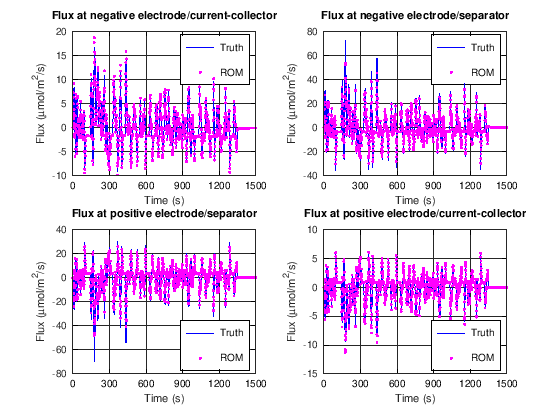

In [10]:
% Plot flux from solid to electrolyte
subplot(2,2,1); % negative electrode, at electrode/current-collector boundary
[~,ind] = min(ROM.locs.j_neg_locs);
plot(t,1e6*FOM.j_neg(:,1),'b-',t,1e6*ROM.j_neg(:,ind),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Flux (\mumol/m^2/s)');
title('Flux at negative electrode/current-collector');
legend('Truth','ROM','location','northeast');

subplot(2,2,2); % negative electrode, at electrode/separator boundary
[~,ind] = max(ROM.locs.j_neg_locs);
plot(t,1e6*FOM.j_neg(:,end),'b-',t,1e6*ROM.j_neg(:,ind),'m.','markersize',5); grid on; 
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Flux (\mumol/m^2/s)');
title('Flux at negative electrode/separator');
legend('Truth','ROM','location','northeast');

subplot(2,2,3); % Positive electrode, at electrode/separator boundary
[~,ind] = max(ROM.locs.j_pos_locs);
plot(t,1e6*FOM.j_pos(:,1),'b-',t,1e6*ROM.j_pos(:,ind),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Flux (\mumol/m^2/s)');
title('Flux at positive electrode/separator');
legend('Truth','ROM','location','southeast');

subplot(2,2,4); % Positive electrode, at electrode/current-collector boundary
[~,ind] = min(ROM.locs.j_pos_locs);
plot(t,1e6*FOM.j_pos(:,end),'b-',t,1e6*ROM.j_pos(:,ind),'m.','markersize',5); grid on;
set(gca,'xtick',0:300:1500); xlim([0 1500]);
xlabel('Time (s)'); ylabel('Flux (\mumol/m^2/s)');
title('Flux at positive electrode/current-collector');
legend('Truth','ROM','location','southeast');

In [11]:
% Final voltage-estimation RMS error (in mV)
Vrms = sqrt(mean((FOM.Vcell(:)-ROM.Vcell(:)).^2))*1000    

% Note that newer techniques than those presented here are able to reduce this error below 1 mV!

Vrms =  1.7652
